## Lecture 2: Modeling

In this notebook we will start with a very simple example of fitting a model. We will use the Self Regulation Ontology data that Dan mentioned in the first lecture.  We will focus on analyzing the reported height data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold, LeaveOneOut, ShuffleSplit
from sklearn.metrics import r2_score
import seaborn as sns

%load_ext rpy2.ipython


/Users/poldrack/anaconda3/envs/py37/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


First let's load the data and look at the histogram for the HeightInches variable.

Text(0.5, 0, 'Height (inches)')

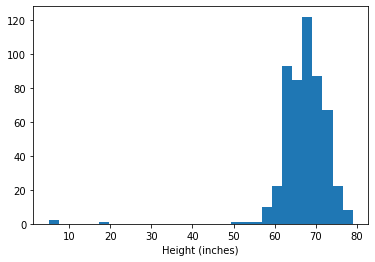

In [41]:
from data_utils import get_SRO_data
SROdata = get_SRO_data()
_ = plt.hist(SROdata['HeightInches'], 30)
plt.xlabel('Height (inches)')

There are clearly some outliers here - sometimes one doesn't necessarily want to remove outliers, but in this case a weight of less than 40 inches is very unlikely for an adult, so we should remove them prior to analysis.  Since we will use the Weight variable later on, we will also filter out implausible values of that variable as well.


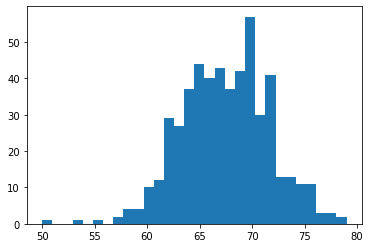

In [44]:
SROdata = SROdata.query('HeightInches > 40 & WeightPounds > 50')
_ = plt.hist(SROdata['HeightInches'], 30)


## A very simple model: the mode

We would like to come up with a model that will ultimately allow us to accurately predict the height for any individual.  One very simple idea might be to just use the mode --- that is, the most common value in the dataset.  

In [4]:
mode_result = scipy.stats.mode(SROdata['HeightInches'])
height_mode = mode_result.mode[0]
height_mode

70

In this simple model, the predicted height for any individual would be 70 inches.  

## Assessing the fit of a model: The loss function

How can we tell if a model is good or bad? One obvious way is to ask how close the predicted values of the model are from the actual values in the data, which we generally refer to as the *error* or *residuals*. A *loss function* is a function that uses the error values to summarize the goodness of fit of the model into a single number: the *loss*.  

A simple measure of the loss that we might imagine is to simply take the mean of the errors.  We can do that for our model which predicts that the height of each individual should be the mode of the dataset:



In [47]:
error_mode =SROdata['HeightInches'] - height_mode
error_mode.mean()

-2.4305019305019306

The average error for any individual is more than 2 inches, which seems like a pretty bad model!


## A better model: The mean

Let's see what happens if we instead use the arithmetic mean as our model.  If we compute the mean error loss for this model:


In [51]:
height_mean = SROdata['HeightInches'].mean()
error_mean = SROdata['HeightInches'] - height_mean
np.allclose(error_mean.mean(), 0)

True

We see that the mean error loss is essentially zero - and we can indeed prove that the mean error for the arithmetic mean must be zero.  Let's look at a histogram of the errors from the mean:



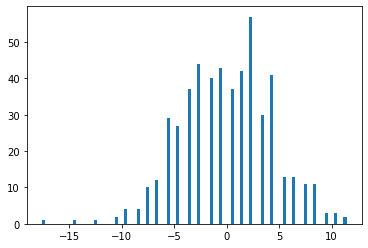

In [7]:
_ = plt.hist(error_mean, 100)

## Squared error loss

We see that although the average error is now zero, there is still a substantial amount of error across individuals when compared to the mean. We need a loss function that doesn't allow the positive and negative errors to cancel each other out; one way to accomplish this is by squaring the errors.  If we sum those, we get the *sum of squared errors*:

$$
SSE = \sum_1^N{(y_i - \bar{y})^2}
$$

In order to make this number more interpretable, let's do two things: divide by the number of observations (giving the *mean squared error*) and then taking the square root to put the values back onto the original scale (giving the *root mean squared error*):

$$
RMSE = \sqrt{\frac{\sum_1^N{(y_i - \bar{y})^2}}{N}}
$$


In [8]:
def RMSE(values, estimate):
    """
    return rmse for a set of values and an estimate
    
    values: array, values to be compared to estimate
    estimate: scalar or array, estimate to be compared to values
    """
    error = values - estimate

    return np.sqrt(error.dot(error)/values.shape[0])

In [9]:
model_RMSE = pd.Series(dtype='float64')

model_RMSE['mean'] = RMSE(SROdata['HeightInches'], height_mean)

model_RMSE['mode']  = RMSE(SROdata['HeightInches'], height_mode)

model_RMSE

mean    4.336920
mode    4.971541
dtype: float64

Here we see that the RMSE for the mean is substantially less than the mode.  In fact, the mean is guaranteed to have the minimum RMSE possible for any single value.  We can see this visually by computing the error for many different values, and plotting them:


Text(0.5, 0, 'target value')

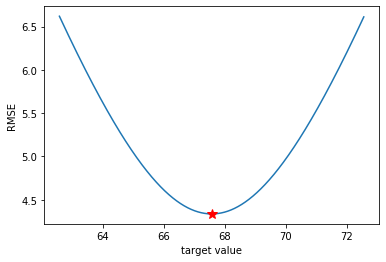

In [10]:
test_values = np.arange(height_mean - 5, height_mean + 5, .01)
rmse_vals = [RMSE(SROdata['HeightInches'], i) for i in test_values]
plt.plot(test_values, rmse_vals)
plt.plot([height_mean], [model_RMSE['mean']], '*', markersize=10, color='red')
plt.ylabel('RMSE')
plt.xlabel('target value')

The mean minimizes the squared error loss. This is closely related to the L2 norm of the error values, which is the square root of the sum of squared errors, and thus:

$$
RMSE = \frac{||y - \hat{y}||_2}{\sqrt{N}}
$$

Text(0.5, 0, 'target value')

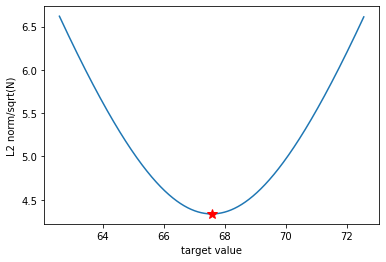

In [11]:
def l2norm_error(values, estimate):
    """
    return l2 norm error (scaled by sqrt(N)) for a set of values and an estimate
    
    values: array, values to be compared to estimate
    estimate: scalar or array, estimate to be compared to values
    """

    error = values - estimate
    return(np.linalg.norm(error)/np.sqrt(error.shape[0]))


l2norm_mean = l2norm_error(SROdata['HeightInches'], height_mean)
l2norm_vals = [l2norm_error(SROdata['HeightInches'], i) for i in test_values]
plt.plot(test_values, l2norm_vals)
plt.plot([height_mean], [l2norm_mean], '*', markersize=10, color='red')
plt.ylabel('L2 norm/sqrt(N)')
plt.xlabel('target value')

## Other loss functions

What if we decided that we wanted to minimize a different loss?  For example, let's say that we instead wanted to minimize the absolute error rather than the squared error:

$$
SAE = \sum_1^N{|y_i - \bar{y}|}
$$

which turns out to be the same as the L1 norm.  Here we will get a slightly different answer - now the mimimum of the loss function falls at the sample *median* (denoted by the red star) rather than the sample mean:


Text(0.5, 0, 'target value')

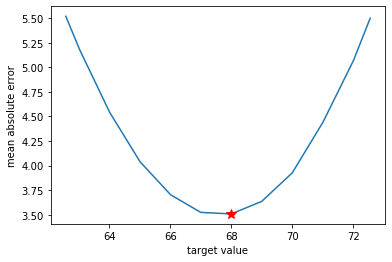

In [12]:
def MAE(values, estimate):
    abserror = np.abs(values - estimate)
    return(np.mean(abserror))

height_median = np.median(SROdata['HeightInches'])
mae_median = MAE(SROdata['HeightInches'], height_median)
mae_vals = [MAE(SROdata['HeightInches'], i) for i in test_values]
plt.plot(test_values, mae_vals)
plt.plot([height_median], [mae_median], '*', markersize=10, color='red')
plt.ylabel('mean absolute error')
plt.xlabel('target value')

## Improving our model

The mean doesn't seem like a particularly good model on its own, because it would have us predict the same height for every adult, when we know that adults are of very different sizes. What happens if we instead fit a model that includes weight, along with an intercept?  

$$ 
\hat{height_i} = \beta_1 * weight_i + \beta_0
$$



We will return to how we actually fit this model in a later session; for now, we will just use the LinearRegression object from scikit-learn. 

## An aside: Object-oriented programming

We are going to use functions from the [scikit-learn](https://scikit-learn.org/stable/) package extensively in this course.  In order to use these effectively, you need to understand the concept of *object-oriented programming*.  First, have a look at the [help page for the LinearRegression object](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).  

You will see that the page first gives a description of the parameters that the function takes:

In [13]:
?LinearRegression

Init signature:
LinearRegression(
    fit_intercept=True,
    normalize=False,
    copy_X=True,
    n_jobs=None,
)
Docstring:     
Ordinary least squares Linear Regression.

LinearRegression fits a linear model with coefficients w = (w1, ..., wp)
to minimize the residual sum of squares between the observed targets in
the dataset, and the targets predicted by the linear approximation.

Parameters
----------
fit_intercept : bool, optional, default True
    Whether to calculate the intercept for this model. If set
    to False, no intercept will be used in calculations
    (i.e. data is expected to be centered).

normalize : bool, optional, default False
    This parameter is ignored when ``fit_intercept`` is set to False.
    If True, the regressors X will be normalized before regression by
    subtracting the mean and dividing by the l2-norm.
    If you wish to standardize, please use
    :class:`sklearn.preprocessing.StandardScaler` before calling ``fit`` on
    an estimator with ``nor

Note that these are aspects of the regression, but they don't actually provide the data needed to perform the analysis.  In scikit-learn, we first set up the LinearRegression *object*, which you can think of as "a tool do to a linear regression".  If you look at the help page, you will see that it also describes a set of *methods*, which you can think of as "things the tool can do".  In this case, one of those is the `fit()` object:

In [14]:
?LinearRegression.fit

Signature: LinearRegression.fit(self, X, y, sample_weight=None)
Docstring:
Fit linear model.

Parameters
----------
X : {array-like, sparse matrix} of shape (n_samples, n_features)
    Training data

y : array-like of shape (n_samples,) or (n_samples, n_targets)
    Target values. Will be cast to X's dtype if necessary

sample_weight : array-like of shape (n_samples,), default=None
    Individual weights for each sample

    .. versionadded:: 0.17
       parameter *sample_weight* support to LinearRegression.

Returns
-------
self : returns an instance of self.
File:      ~/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_base.py
Type:      function


It is this `fit()` method that actually takes in the data and estimates the best parameters for the model. Let's see this in action for the relation of age and height:

In [62]:
lr = LinearRegression()
lr.fit(SROdata[['WeightPounds']], SROdata['HeightInches'])


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Note that for the X variable we passed a full data frame with the Weight variable (using the double brackets), whereas for the y variable we passed a single variable, which is a Series.  If you look at the help for the `LinearRegression.fit()` object, you can see why we needed to do this: the X variable is required to have two dimensions.  Let's see what the dimensions of these different objects are:

In [16]:
print(type(SROdata[['WeightPounds']]))
SROdata[['WeightPounds']].shape


<class 'pandas.core.frame.DataFrame'>


(518, 1)

In [17]:
print(type(SROdata['HeightInches']))
SROdata['HeightInches'].shape

<class 'pandas.core.series.Series'>


(518,)

You see that the DataFrame object created using the double brackets has a second dimension, whereas the Series object created using the single brackets has an empty second dimension.  For this reason, we need to use the double brackets for the X variable; we can do it either way for the y variable.

After the model is fitted, the LinearRegression object that we created now contains the estimated parameters of the model:

In [18]:
print('slope:', lr.coef_)
print('intercept:', lr.intercept_)


slope: [0.03972741]
intercept: 60.42193843195674


One nice thing about this is that we can now simply pass the object into a function, which can use the contents of the object. Here is an example to create a plot of the regression line:

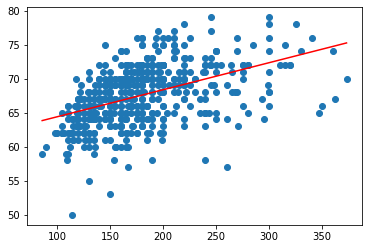

In [19]:

def regression_plot(X, y, lr, poly=None):
    """
    given X and y values and an lr object,
    plot the data with the regression line
    desmtx: allows us to specify a more complex design
    poly: polynomial order (default is linear)
    """

    plt.scatter(X, y)
    pred_X = np.arange(X.min(), X.max()+.01, .01)
    
    if poly is None:
        plt.plot(pred_X, lr.predict(pred_X.reshape(-1, 1)), color='red')
    else:
        polyfit = PolynomialFeatures(poly)
        desmtx = polyfit.fit_transform(pred_X.reshape(-1, 1) - np.mean(pred_X))
        plt.plot(pred_X, lr.predict(desmtx), color='red')


regression_plot(SROdata['WeightPounds'], SROdata['HeightInches'], lr)

The LinearRegression object also has a `predict()` method that takes in an X variable and returns the predicted values of y for each X. We can use this to compute the RMSE for this model:

In [20]:
model_RMSE['weight']  = RMSE(SROdata['HeightInches'], lr.predict(SROdata[['WeightPounds']]))
model_RMSE

mean      4.336920
mode      4.971541
weight    3.847576
dtype: float64

This is obviously a much better model, right?  

## Overfitting

We generally want our model to fit well, but it's possible for a model to fit *too* well.  To see this, let's generate some data where we know the true generative model for the data (which in this case is a linear model).


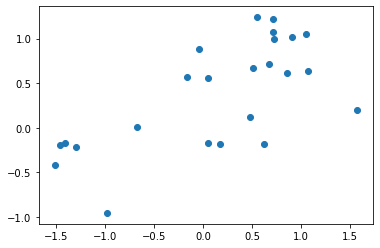

In [21]:
# set the random seed so that the example is reproducible
np.random.seed(12345678)


simDf = pd.DataFrame({'X':np.random.randn(24)})
simDf['Y'] = simDf['X']*0.5 + np.random.randn(24)*0.5

plt.scatter(simDf.X, simDf.Y)

First let's look at a linear fit.

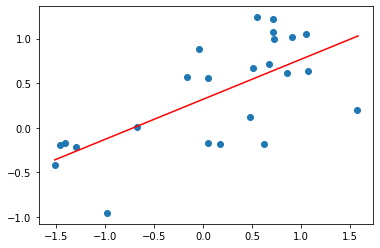

In [22]:
lr = LinearRegression()
## lr.fit wants an Nx1 array for the X variable, and a vector for the Y variable
lr.fit(simDf[['X']], simDf['Y'])

regression_plot(simDf['X'], simDf['Y'], lr)

sim_RMSE = pd.Series(dtype='float64')
sim_RMSE['linear_orig'] = RMSE(simDf['Y'], lr.predict(simDf[['X']]))


Now let's fit the same data with a much more complex model: a 8th-order polynomial.  We can use the sklearn function `PolynomialFeatures()` to generate this:

In [23]:
poly_order = 8
polyfit = PolynomialFeatures(poly_order)
# demean the original variable
X = polyfit.fit_transform(simDf[['X']] - simDf['X'].mean())
lr_poly = LinearRegression()
lr_poly.fit(X, simDf['Y'])

sim_RMSE['poly_orig']  = RMSE(simDf['Y'], lr_poly.predict(X))
sim_RMSE

linear_orig    0.437527
poly_orig      0.319017
dtype: float64

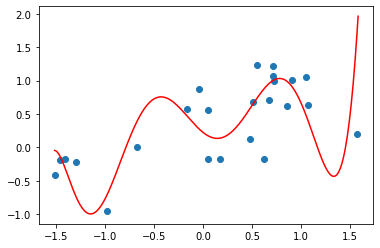

In [24]:
regression_plot(simDf['X'], simDf['Y'], lr_poly,poly=poly_order)

Here we see that the RMSE is much lower than for the linear model - even though we know that the linear model is the right one!  This is because we are *overfitting* the data - that is, our parameter estimates are increasingly reflecting the random noise in the data, rather than the underlying mechanism.  To see this, let's generate another dataset from the same linear function (with different random noise) and see how well our two models (fitted to the previous dataset) generalize to the new data:

In [25]:
simDf['Y_new'] = simDf['X']*0.5 + np.random.randn(24)*0.5

sim_RMSE['poly_new']  = RMSE(simDf['Y_new'], lr_poly.predict(X))
sim_RMSE['linear_new'] = RMSE(simDf['Y_new'], lr.predict(simDf[['X']]))
sim_RMSE

linear_orig    0.437527
poly_orig      0.319017
poly_new       0.682834
linear_new     0.577010
dtype: float64

Now we see that the polynomial model has substantially *higher* RMSE than the linear model on the new data. A more complex model will always fit a particular dataset better than a less complex model, but their ability to predict values for a new dataset will depend on the actual complexity of the underlying process that generates the data.

## Cross-validation

In the previous example, we were able to generate a new dataset from the same underlying process. However, it is usually not feasible for us to generate an entirely new dataset to test our model. Fortunately, there is a way for us to test the generalization ability of our model that works almost as well as testing our model on completely new data: *cross-validation*.  

The idea behind cross-validation is that we split our data into multiple sections (or *folds*), and then iteratively leave out one of the folds, fit the model on the remaining folds (known as the *training* data) and then assess the model fit on the held-out (or *test*) data.  For this to work, it is *absolutely essential* that there is no crosstalk between the training and test folds.  It is also important to have sufficiently large data in order to obtain stable estimates of test accuracy; there is no set number that is "large enough" but an emerging rule of thumb is that it rarely makes sense to perform cross-validation with less than 100 samples.  Otherwise we risk highly variable estimates of accuracy (as shown by Varoquaux in his [Cross-validation failure](https://arxiv.org/abs/1706.07581) paper).

Let's see an example in action.  First we generate some data.

In [26]:
# generate data using 10 random regressors with random parameters
np.random.seed(12345)
npts = 100
nvars = 20
noise_sd = 5
X = np.random.randn(npts, nvars)
beta = np.zeros((nvars, 1))
beta[3, 0] = 4
y = X.dot(beta) + np.random.randn(npts, 1)*noise_sd
y_new = X.dot(beta) + np.random.randn(npts, 1)*noise_sd


Now let's fit a linear model on the full dataset and assess its fit.  We will assess the fit using the coefficient of variation, aka *R-squared*, which denotes the proportion of variance accounted for in the data.

In [27]:
# first run standard linear regression and compute r-squared

lr = LinearRegression()
lr.fit(X, y)
lr.score(X, y)

0.5437181447922388

Also test on new data:

In [28]:
lr.score(X, y_new)

0.3196720815084986

Here we see that our model accounts for a large amount of variance in our sample, but the same model accounts for substantially less variance in a new sample.  Now let's perform cross-validation. We will use the `KFold()` object from sklearn to create the training and test folds.  first let's see a simple version of how this works (from the sklearn documentation):

In [29]:
X_simple = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y_simple = np.array([1, 2, 3, 4])
kf = KFold(n_splits=2)
for train_index, test_index in kf.split(X_simple):
     print("TRAIN:", train_index, "TEST:", test_index)
     X_train, X_test = X_simple[train_index], X_simple[test_index]
     y_train, y_test = y_simple[train_index], y_simple[test_index]


TRAIN: [2 3] TEST: [0 1]
TRAIN: [0 1] TEST: [2 3]


The cross-validation operator returns the indices of the rows in the data that should be assigned to training or test for that particular fold.  Now let's do this on our data, using 10-fold cross-validation.

In [30]:
# create cross-validation operator, 
# shuffling row order to prevent any bias between folds
kf = KFold(n_splits=10, shuffle=True)

# loop through the folds
predicted = np.zeros((npts, 1))
for train_index, test_index in kf.split(X):
    # create separate train and test datasets for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # train the model
    lr.fit(X_train, y_train)
    predicted[test_index] = lr.predict(X_test)


# compute r-squared for out-of-sample predictions
r2_score(y, predicted)

0.2772295193686999

Here we see that the goodness of fit for the crossvalidated predictions are very close to those obtained using a new dataset generated from the same mechanism.

## Cross-validation for model selection

So far we have seen how we can use cross-validation to get an accurate estimate of how well our model can generalize to a new sample. We can also use cross-validation to compare different models, since the error on the test data provides us with a measure of how well our model fits new data, which will not be inflated by the complexity of the model.

To see this, let's generate some data where the true underlying function is a third order polynomial, and use cross-validation to find the model with the best generalization performance.


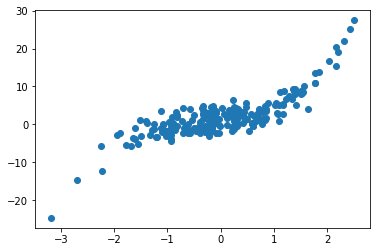

In [31]:
# functions to generate polynomial data for simulation

def poly_generate(x, params):
    """
    generate polynomial function of x given parameters
    x: values to transform
    params: an array of parameters for each polynomial
    """

    powers = np.arange(params.shape[0])
    s = [np.sum(i**powers) for i in x]

    return(np.array(s))

def make_poly_df(npts, params, x_sd = 1, noise_sd = 1):
    X = np.random.randn(npts)*x_sd
    y = poly_generate(X, params) + np.random.randn(npts)*noise_sd
    polyDf = pd.DataFrame({'x':X, 'y':y})
    return(polyDf)

params = np.array([0, 2, -0.4, 1.5])
npts=200
polyDf = make_poly_df(npts, params, noise_sd=2)

plt.scatter(polyDf.x, polyDf.y)

In [32]:
# use crossvalidation to test a range of polynomial model complexities

# create cross-validation operator, 
# shuffling row order to prevent any bias between folds
# use 4 splits here to make things faster
n_splits = 4
kf = KFold(n_splits=n_splits)

# polynomial model orders to test
max_order = 10
poly_orders = np.arange(0, max_order)

X = polyDf[['x']].values
X = X - X.mean()
y = polyDf.y.values

# loop through the folds
predicted = np.zeros((npts, max_order))
errorDf = pd.DataFrame({'order': poly_orders,
                        'train': np.zeros(max_order),
                        'test': np.zeros(max_order)})

for train_index, test_index in kf.split(X):
    # create separate train and test datasets for this fold
    y_train, y_test = y[train_index], y[test_index]

    # loop through the polynomial expansions
    train_errors = []
    for i, poly_order in enumerate(poly_orders):
        polyfit = PolynomialFeatures(poly_order)

        X_train = polyfit.fit_transform(X[train_index])
        X_test = polyfit.fit_transform(X[test_index])

        # train the model
        lr.fit(X_train, y_train)
        errorDf.loc[i, 'train'] = 1 - errorDf['train'].iloc[i] + r2_score(y_train, lr.predict(X_train))/n_splits
        predicted[test_index, i] = lr.predict(X_test)



Found best test fit for order =  3


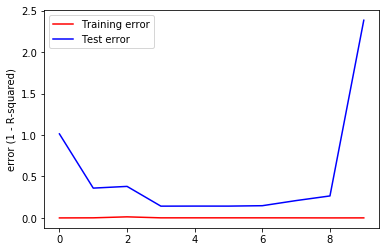

In [33]:
# get prediction errors
for i, poly_order in enumerate(poly_orders):
    errorDf.loc[i, 'test'] = 1 - r2_score(y, predicted[:,i])

# plot fit indices
plt.plot(errorDf.order, errorDf.train, color='red')
plt.plot(errorDf.order, errorDf.test, color='blue')
plt.legend(['Training error', 'Test error'])
plt.ylabel('error (1 - R-squared)')
print('Found best test fit for order = ', np.argmin(errorDf.test))


Crossvalidation found the correct model order in this case.



## Choosing the right cross-validation method

It is important to choose the right cross-validation method as well as the right metric for assessing fit. For example, let's say that you want to use cross-validation to assess the ability to predict disease symptoms from a set of 10 biomarkers, all of which are continuously distributed.  

Let's first generate some data in which there is no relationship between the two variables - all of the values are simply random noise.

In [34]:
npts = 24
nvars = 10

np.random.seed(0)
X = np.random.randn(npts, nvars)
y = np.random.randn(npts, 1)

Now let's say that you decide to use leave-one-out crossvalidation to assess our ability to predict the symptom measure from the biomarker out of sample.


In [35]:
loo = LeaveOneOut()

predicted = np.zeros((npts, 1))
for train_index, test_index in loo.split(X):
    # create separate train and test datasets for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # train the model
    lr.fit(X_train, y_train)
    predicted[test_index] = lr.predict(X_test)


You compute $R^2$ for your predictions to see how well the model worked:

In [36]:
r2_score(y, predicted)

-1.2844083728531248

Huh? How can $R^2$ be negative?  It turns out that this can happen when the predictive model fits particularly badly -- worse than if one had simply used the sample mean as the prediction.  In this particular case, what has happened is that the regression model overfits to the training data, leading to a negatively correlated prediction when the left-out value has a strong impact on the regression model.  Using shuffle-split or balanced cross-validation methods can help address this.

## Keeping a firewall between training and test data

Perhaps the most important rule of cross-validation is this: **There must be no contamination of the test data with the training data.**  Let's see what happens when this rule is broken.  We will once again generate a dataset with no relation between the X and y variables, using a large number of X variables and a relatively small number of observations (e.g. as people often would in fMRI):

In [37]:
npts = 32
nvars = 100000

np.random.seed(0)
X = np.random.randn(npts, nvars)
y = np.random.randn(npts, 1)

We can perform crossvalidation (this time using ShuffleSplit) to confirm that there is no predictive relationship.

In [38]:
ss = ShuffleSplit(n_splits=4)

predicted = np.zeros((npts, 1))
for train_index, test_index in ss.split(X):
    # create separate train and test datasets for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # train the model
    lr.fit(X_train, y_train)
    predicted[test_index] = lr.predict(X_test)
    
r2_score(y, predicted)

-0.005598993357100568

Now let's say that we first decide to select the best variables, before we perform cross-validation.  For example, we could pick the 5 X variables that are most strongly associated with the y variable (due to random noise):

In [39]:
coefs = np.zeros(nvars)
lr = LinearRegression()
for i in range(nvars):
    coefs[i] = np.corrcoef(X[:, i], y[:,0])[0,1]
best_vars = np.argsort(np.abs(coefs))[99995:]
X_filtered = X[:, best_vars]

If we then perform cross-validation after variable selection, we will see that there is a large (but illusory) increase in the apparent predictive ability of the model:

In [40]:
predicted = np.zeros((npts, 1))
for train_index, test_index in ss.split(X_filtered):
    # create separate train and test datasets for this fold
    X_train, X_test = X_filtered[train_index],X_filtered[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # train the model
    lr.fit(X_train, y_train)
    predicted[test_index] = lr.predict(X_test)
    
r2_score(y, predicted)

0.3312042228690427

Any processing that is going to be applied to the data (such as variable selection or parameter tuning) must be performed within the cross validation loop.   